In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm

import seaborn as sns
import pyreto

In [1]:
from IPython.core.display import HTML
HTML("./custom.css")

<h1>How big are your banks?</h1>
<h2>The ones in the U.S. are <em>pretty</em> big!</h2>

<h3>Dr. David R. Pugh</h3>

<img src="./assets/img/pydata-logo-amsterdam-2016.png" alt="PyData Amsterdam">
<h4>Amsterdam, The Netherlands, 12-13 March 2016</h4>

<img src="../../assets/img/INET_Brand_Final-01.png" alt="Institute for New Economic Thinking" width=500>

<h1> Motivation </h1>

I am currently working on building data-driven, large-scale, agent-based/multi-agent systems models of economic systems. Banks are important part of modern economic systems and I would like my banking sector to be realistically calibrated.

<strong>Primary motivation is to establish "facts on the ground" concerning the distribution of U.S. banks and how it has evolved (or not!) over time as a precursor to calibrating my simulation models.</strong>

<h2>I have a hypothesis!</h2>

I suspect that the upper tail of the bank size distribution might follow a power law...

$$ p(x; x_{min}, \alpha) = \left(\frac{\alpha - 1}{x_{min}}\right)\left(\frac{x_{min}}{x}\right)^{\alpha} $$

...more specifically, I think that Zipf's Law (i.e., power law with $\alpha = 2$) is a pretty decent null hypothesis.

Why? Strong empirical evidence from <a href="http://www.uvm.edu/~pdodds/files/papers/others/2001/axtell2001a.pdf">Axtell (<em>Science</em>, 2001)</a> (and <em>many</em> others!) that distribution of <em>firm sizes</em> is well decribed by Zipf's Law. Maybe banks are like firms?

<h1> Data </h1>

<h3> Statistics on Depository Institutions </h3>

<p>Data used in this study are taken from the <a href="http://www2.fdic.gov/sdi/index.asp">Statistics on Depository Institutions (SDI)</a> database maintained by the U.S. Federal Deposit Insurance Corporation (FDIC).<p>

FDIC makes it hard to access the SDI data in bulk...so I wrote a little Python scripts to crawl the FDIC's website and download the data, and format it into a Pandas Panel object.

SDI data set contains aggregate demographic and financial information about the U.S. banking sector, as well detailed <em>quarterly</em> data on individual bank (or bank holding company) balance sheets, income statements, performance ratios, etc., dating back to 1992.

<p>I look at six separate measures of bank size:</p>
<ul>
  <li><strong>Total assets (`asset`):</strong> The sum of all assets owned by the institution including cash, loans, securities, bank premises and other assets. This total does not include off-balance-sheet accounts.</li>
  <li><strong>Total loans (`lnlsnet`):</strong> Total loans and lease financing receivables minus unearned income and loan loss allowances.</li>
  <li><strong>Total liabilities (`liab`):</strong> Deposits and other borrowings, subordinated notes and debentures, limited-life preferred stock and related surplus, trading account liabilities and mortgage indebtedness.</li>
  <li><strong>Total deposits (`dep`):</strong> The sum of all deposits including demand deposits, money market deposits, other savings deposits, time deposits and deposits in foreign offices.</li>
  <li><strong>Total equity (`toteq`):</strong> Total equity capital on a consolidated basis.</li>
  <li><strong>Total employees (`numemp`):</strong> The number of full-time employees on the payroll of the bank and its subsidiaries at the end of the quarter.</li>
</ul>

Interested in the <em>shape</em> of the size distribution: I deflate and then re-scale each measure of bank size by dividing by banking sector totals relative to some base year, $T$...

$$  S_{i,t}^{norm} = \left(\frac{\sum_{j}S_{i, T}^{raw}}{\sum_{j}S_{j,t}^{raw}}\right)S_{i,t}^{raw}. $$

In case anyone asks...
<ul>
  <li>$S_{i,t}^{raw}$ denotes the raw size of bank $i$ in year $t$ based on one of the six size measures detailed above.</li>
  <li>$\sum_{j}S_{j,t}^{raw}$ is the banking sector total of some size measure in year $t$.</li>
  <li>$\sum_{j}S_{j,T}^{raw}$ is the banking sector total of the same size measure in the base year.</li>
</ul>

In [5]:
# load the raw FDIC SDI data...
fdic_sdi_panel = pd.read_pickle('./FDIC_SDI_panel_nominal.pkl')

In [6]:
print(fdic_sdi_panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 16523 (major_axis) x 92 (minor_axis)
Items axis: numemp to eqtot
Major_axis axis: 8 to 91393
Minor_axis axis: 1992-12-31 00:00:00 to 2015-09-30 00:00:00


In [7]:
def normalize_size_measure(size_measure, base_date='2015-09-30'):
    """Normalize the raw data for some size measure."""
    base_date_totals = fdic_sdi_panel.minor_xs(base_date)[size_measure].sum()
    scaling_factor = base_date_totals / fdic_sdi_panel.asset.sum()
    return scaling_factor * fdic_sdi_panel[size_measure]


def nlargest_banks_share(item, n):
    """Compute the market share of a data item for the n largest banks."""
    data = fdic_sdi_panel[item]
    dates = fdic_sdi_panel.minor_axis
    nlargest_banks = pd.concat([data.nlargest(n, date)[date] for date in dates], axis=1)
    return nlargest_banks.sum() / fdic_sdi_panel[item].sum()


def plot_nlargest_bank_share(n, figsize=(10, 8)):
    """Plot the market share of the n largest banks for each size measure."""
    # create the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for size_measure in fdic_sdi_panel.items:
        data = nlargest_banks_share(size_measure, n)
        data.plot(ax=ax, label=size_measure)
    
    # format the axis
    ax.legend(loc=0, frameon=False)
    ax.set_xlabel('Report date', fontsize=20)
    ax.set_ylabel('Market share', fontsize=20)
    
    return fig


def plot_number_regulated_banks(figsize=(10, 8)):
    """Plot a times series of the number of FDIC reguated banks."""
    # create the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    data = fdic_sdi_panel.asset.count()
    data.plot(ax=ax)

    # apply formatting
    ax.set_xlabel('Report date', fontsize=20)
    ax.set_ylim(0, 15000)
    ax.set_ylabel('Number of FDIC regulates banks', fontsize=20)
    ax.set_title('Impact of Mergers and Acquisitions', fontsize=25)
    
    return fig

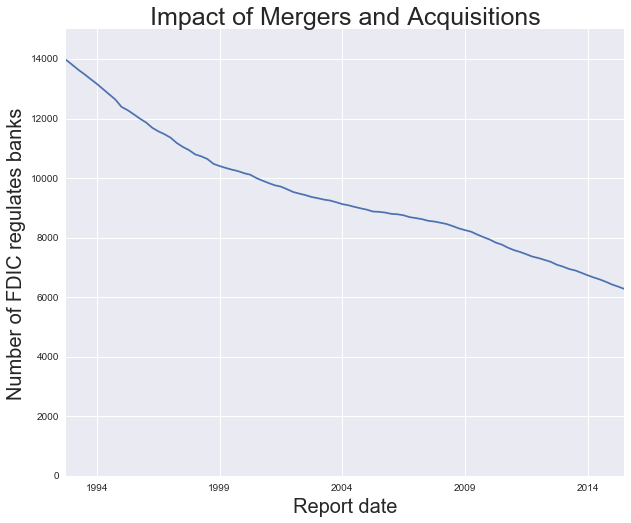

In [356]:
fig = plot_number_regulated_banks()
fig.savefig('./assets/img/number-fdic-regulated-banks.jpg')

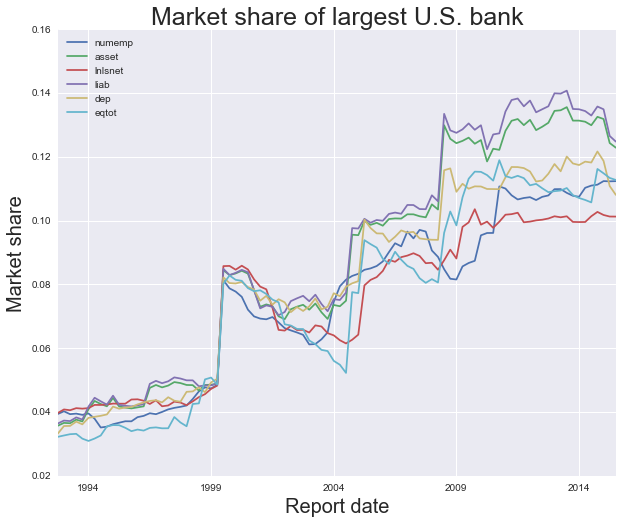

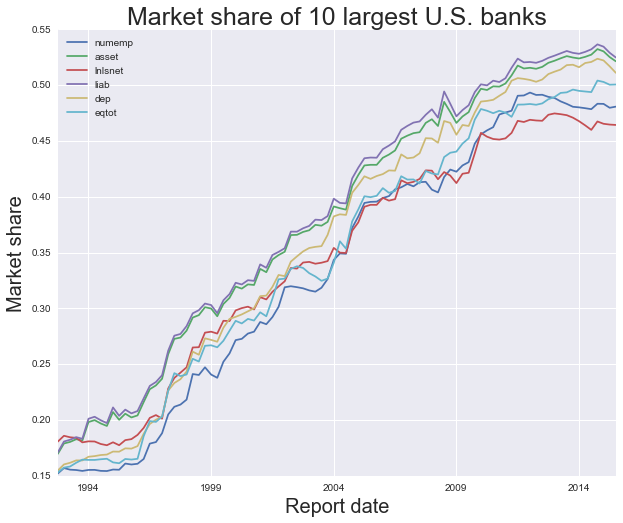

In [8]:
fig = plot_nlargest_bank_share(1)
fig.axes[0].set_title("Market share of largest U.S. bank", fontsize=25)
fig.savefig('./assets/img/largest-bank-market-share.jpg')

fig = plot_nlargest_bank_share(10)
fig.axes[0].set_title("Market share of 10 largest U.S. banks", fontsize=25)
fig.savefig('./assets/img/nlargest-banks-market-share.jpg')

<h2>Significant agglomeration within the U.S. banking sector...</h2>

<img src="./assets/img/number-fdic-regulated-banks.jpg" alt="Effect of M&A" width=1000>

<h2> Summary </h2>
Major consolidation of the U.S. banking sector over the past 20+ years...
<ul>
  <li>Q1 1992: $\approx$ 14,000 banks in the data; largest bank (Citibank), controlled $\approx$ 4% of all U.S. banking assets.</li>
  <li>Q3 2015, $\approx$ 6,000 banks remain; largest bank (now JP Morgan-Chase), controlled $\approx$ 13% of all U.S. banking assets.</li>
  <li>"Jumps" in the share of assets and liabilities controlled by the largest U.S. bank all occurred because of mergers between large banks:
    <ul>
      <li>1999: Nations Bank (largest U.S. bank in 1999), merged with Bank of America.</li> 
      <li>2004: JPMorgan-Chase (the largest bank in 2003), purchased Bank One (6th largest bank).</li>
      <li>2008: JPMorgan-Chase acquired both Bear Stearns and Washington Mutual</li>
    </ul>
  </li>
  <li>"Jumps" in market shares also hint at another important stylized fact: there seems to be no preferred scale for bank mergers and acquisitions.</li>
</ul>

...extent of agglomeration within the banking sector even more dramatic when one examines the market shares held by the ten largest U.S. banks. 

<ul>
  <li>Market share of 10 largest banks has more than doubled from less than 20% to roughly 50%.</li>
</ul>


<img src="./assets/img/largest-bank-market-share.jpg" alt="Market share of largest bank" width=1000>

<img src="./assets/img/nlargest-banks-market-share.jpg" alt="Market share of 10 largest banks" width=1000>

In [17]:
def plot_survival_functions(figsize=(12, 8), sharex=True, sharey=True):
    dates = fdic_sdi_panel.minor_axis

    fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=sharex, sharey=sharey)
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax = axes.flatten()[i]

        df = normalize_size_measure(size_measure)

        for t, date in enumerate(fdic_sdi_panel.minor_axis):
            series = df[date].dropna()
            ecdf = sm.distributions.ECDF(series)
            if t == 0:
                ax.plot(ecdf.x[1:-1], 1 - ecdf.y[1:-1], alpha=0.5, label="1992")
            elif t == (fdic_sdi_panel.minor_axis.size - 1):
                ax.plot(ecdf.x[1:-1], 1 - ecdf.y[1:-1], alpha=0.5, color='r', label="2015")
            else:
                ax.plot(ecdf.x[1:-1], 1 - ecdf.y[1:-1], alpha=0.01, color='k')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()

        if i in [0, 3]:
            ax.set_ylabel(r'$1 - F(x)$', fontsize=20)
        if i in [3, 4, 5]:
            ax.set_xlabel("Report Date", fontsize=20)

        # map size measure variable to better title...
        if size_measure == 'asset':
            ax.set_title("Assets", fontsize=20)
        elif size_measure == 'dep':
            ax.set_title("Deposits", fontsize=20)
        elif size_measure == 'liab':
            ax.set_title("Liabilities", fontsize=20)
        elif size_measure == 'eqtot':
            ax.set_title("Equity", fontsize=20)
        elif size_measure == 'lnlsnet':
            ax.set_title("Loans", fontsize=20)
        else:
            ax.set_title("Employees", fontsize=20)
    fig.suptitle("Survival functions", x=0.5, y=1.05, fontsize=25)
    fig.tight_layout()
    
    return fig

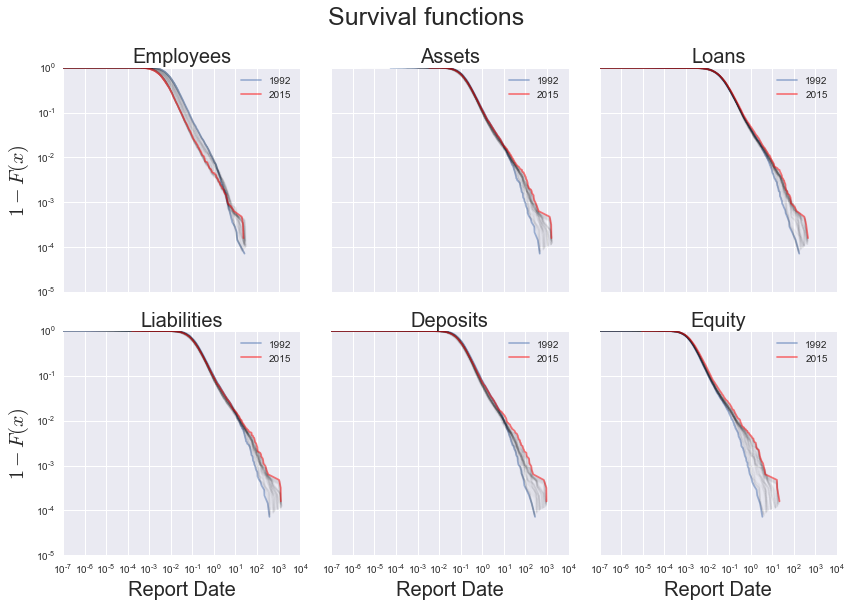

In [18]:
fig = plot_survival_functions()
fig.savefig('./assets/img/sf-various-size-measures.jpg', bbox_inches='tight')

<img src="./assets/img/sf-various-size-measures.jpg" alt="Survival functions for various size measures" width=1000>

<h2>Methodology</h2>

Follow the methodology advocated by <a href="http://arxiv.org/abs/0706.1062">Clauset et al (SIAM, 2009)...</a>

<h3> Maximum Likelihood Estimator </h3>

Assuming data $x_i,\ i=i,\dots,n$ are <em>independent</em>, then, for a given value of $x_{min}$, the maximum likelihood estimator for the scaling exponent is

$$ \hat{\alpha} = 1 +  n\left[\sum_{i=1}^{n}\mathrm{ln}\ \left(\frac{x_{i}}{x_{min}}\right)\right]^{-1}. $$

The maximum likelihood estimator is equivalent to the Hill Estimator widely used in Extreme Value statistics.

In [19]:
def parameter_estimation(base_date, normalize=True, method='bounded'):
    results = {}
    for size_measure in fdic_sdi_panel.items:
        results[size_measure] = {}
        if normalize:
            df = normalize_size_measure(size_measure, base_date)
        else:
            df = fdic_sdi_panel[size_measure]
        for date in fdic_sdi_panel.minor_axis:
            data = df[date]
            fit = pyreto.distributions.Pareto.fit(data, xmin=None, method=method)
            results[size_measure][date] = fit
    return results

In [20]:
estimation_results = parameter_estimation(base_date = '2015-09-30', method='bounded')

But this maximum likelihood estimator holds only for a <em>given</em> value of $x_{min}$. The procedure for choosing $x_{min}$ is basically a brute force search:
<ol>
  <li>Choose a set of candidate threshold parameters, $\Theta$ from the observed data.</li>
  <li>For each $x_{min}^{c} \in \Theta$ obtain an estimate of the scaling exponent $\hat{\alpha}^{c}$ using maximum likelihood and then calculates the Kolmogorov-Smirnov (KS) distance between the empirical distribution of the data above $x_{min}^c$ and the theoretical distribution of a power law with parameters $\hat{\alpha}^{c}$ and $x_{min}^c$.</li>
  <li>Optimal choice for the threshold parameter, $x_{min}$, is the $x_{min}^{*} \in \Theta$ which minimizes the KS distance between the observed data above $x_{min}^{*}$ and the theoretical power law distribution with scaling exponent, $\hat{\alpha}^{*}$.</li>
</ol>

<p>In order to get estimates of parameter uncertainty that accurately take into account the flexibility introduced by the joint estimation of $\alpha$ and $x_{min}$, standard errors and confidence intervals for the parameter estimates are estimated using a basic non-parametric bootstrap procedure.</p>

<h3>Likelihood Ratio Tests</h3>

<p>I use a <a href="https://en.wikipedia.org/wiki/Vuong%27s_closeness_test">Vuong likelihood ratio test</a> implemented in two steps to test off the power law model against various alternatives...</p>
<ol>
  <li> Consider the two-sided null hypothesis that each of the power law and the alternative are equally far from the "true distribution" against a general alternative.  If I reject this two-sided null hypothesis, then I conclude that one of the power law or the alternative is preferred (given the data).</li>
  <li> Second I consider a one-sided null hypothesis of a power law against the alternative distribution directly.</li>
</ol>
  
<p>A rejection of the two-sided null hypothesis, followed by a failure to reject the one-sided null hypothesis of a power law implies the data are sufficient to distinguish between the power law and the considered alternative, and the the power law model if preferred.</p>

A major advantage of using the Vuong likelihood ratio test over the classic likelihood ratio test is that the former will alert the researcher to the possibility that the data are not sufficient to favor either the power law or the alternative model.

<h1>Results</h1>

<h2>Parameter estimates</h2>

In [21]:
def plot_estimated_scaling_threshold(estimation_results, figsize=(12, 8), sharey=True):
    fig, axes = plt.subplots(2, 3, figsize=figsize, sharey=sharey)

    dates = fdic_sdi_panel.minor_axis
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax = axes.flatten()[i]
        ax1 = ax.twinx()
        
        tmp_results = estimation_results[size_measure]
        n_tails = pd.Series({date: tmp_results[date].n_tail for date in dates})
        ns = fdic_sdi_panel[size_measure].count()
        tail_fractions = n_tails / ns
        xmins = pd.Series({date: tmp_results[date].xmin for date in dates})
        xmins.plot(ax=ax)
        tail_fractions.plot(ax=ax1, color='r')

        # axis specific formatting
        if i in [0, 3]:
            ax.set_ylabel(r'$\hat{x}_{min}$', rotation=0, fontsize=20)
        if i in [3, 4, 5]:
            ax.set_xlabel("Report Date", fontsize=20)
        if i in [2, 5]:
            ax1.set_ylabel(r'$\frac{n_{tail}}{n}$', rotation=0, fontsize=20)
        ax1.set_ylim(0, 1)
        
        # map size measure variable to better title...
        if size_measure == 'asset':
            ax.set_title("Assets", fontsize=20)
        elif size_measure == 'dep':
            ax.set_title("Deposits", fontsize=20)
        elif size_measure == 'liab':
            ax.set_title("Liabilities", fontsize=20)
        elif size_measure == 'eqtot':
            ax.set_title("Equity", fontsize=20)
        elif size_measure == 'lnlsnet':
            ax.set_title("Loans", fontsize=20)
        else:
            ax.set_title("Employees", fontsize=20)
    
    fig.suptitle("Estimated Scaling Threshold", x=0.5, y=1.05, fontsize=25)
    fig.tight_layout()
    
    return fig

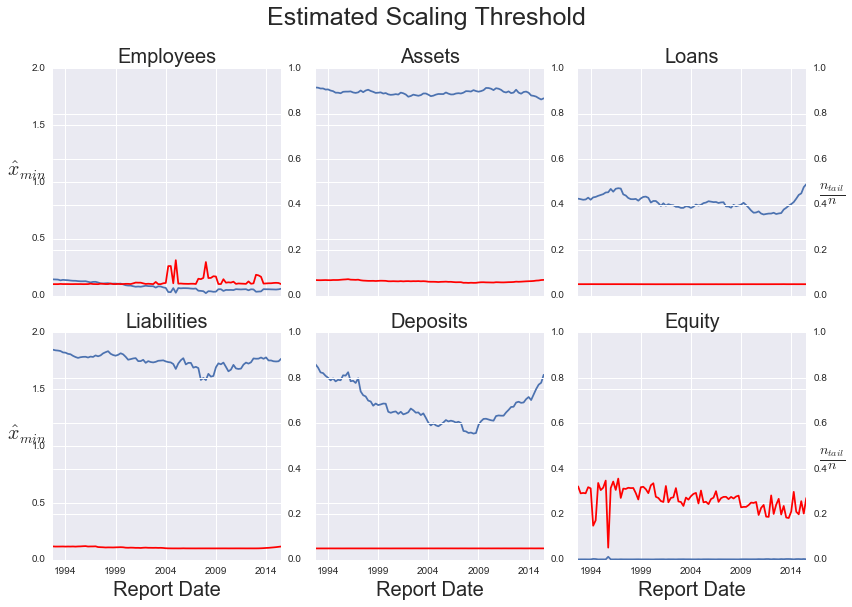

In [22]:
fig = plot_estimated_scaling_threshold(estimation_results)
fig.savefig('./assets/img/estimated-scaling-threshold.jpg', bbox_inches='tight')

In [23]:
def plot_estimated_scaling_exponents(estimation_results, figsize=(12, 8), sharey=True):
    fig, axes = plt.subplots(2, 3, figsize=figsize, sharey=sharey)

    dates = fdic_sdi_panel.minor_axis
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax = axes.flatten()[i]
        ax1 = ax.twinx()
        
        tmp_results = estimation_results[size_measure]
        n_tails = pd.Series({date: tmp_results[date].n_tail for date in dates})
        ns = fdic_sdi_panel[size_measure].count()
        tail_fractions = n_tails / ns
        alphas = pd.Series({date: tmp_results[date].params['alpha'] for date in dates})
        alphas.plot(ax=ax)
        tail_fractions.plot(ax=ax1, color='r')
        
        # plot classic MLE confidence intervals...
        alpha_ses = pd.Series({date: tmp_results[date].standard_errors['alpha'] for date in dates})
        lower = alphas - 1.96 * alpha_ses
        upper = alphas + 1.96 * alpha_ses
        ax.fill_between(alpha_ses.index, lower, upper, color='grey', alpha=0.5)
        ax.axhline(2.0, color='k', linestyle='dashed', label="Zipf's Law")

        # axis specific formatting
        if i in [0, 3]:
            ax.set_ylabel(r'$\hat{\alpha}$', rotation=0, fontsize=20)
        if i in [3, 4, 5]:
            ax.set_xlabel("Report Date", fontsize=20)
        if i in [0, 1, 3, 4]:
            ax1.tick_params(axis='y', right='off', labelright='off')
        if i in [2, 5]:
            ax1.set_ylabel(r'$\frac{n_{tail}}{n}$', rotation=0, fontsize=20)
        ax1.set_ylim(0, 1)
        
        # map size measure variable to better title...
        if size_measure == 'asset':
            ax.set_title("Assets", fontsize=20)
        elif size_measure == 'dep':
            ax.set_title("Deposits", fontsize=20)
        elif size_measure == 'liab':
            ax.set_title("Liabilities", fontsize=20)
        elif size_measure == 'eqtot':
            ax.set_title("Equity", fontsize=20)
        elif size_measure == 'lnlsnet':
            ax.set_title("Loans", fontsize=20)
        else:
            ax.set_title("Employees", fontsize=20)
    
    fig.suptitle("Estimated Scaling Exponents", x=0.5, y=1.05, fontsize=25)
    fig.tight_layout()
    
    return fig

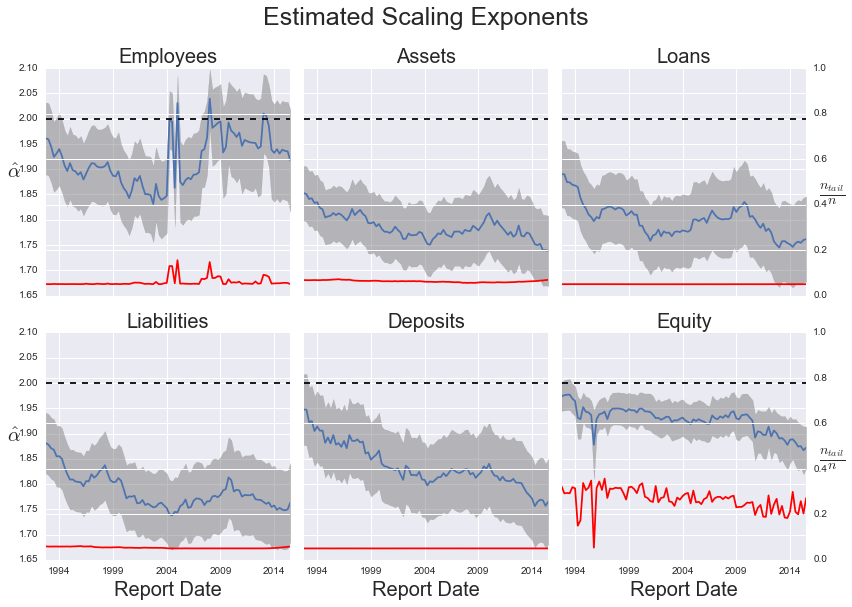

In [24]:
fig = plot_estimated_scaling_exponents(estimation_results)
fig.savefig('./assets/img/estimated-scaling-exponents.jpg', bbox_inches='tight')

<img src="./assets/img/estimated-scaling-exponents.jpg" alt="Estimated scaling exponents">

<img src="./assets/img/estimated-scaling-threshold.jpg" alt="Estimated scaling thresholds">

<h2>Summary</h2>
<ul>
  <li>For most size measures, in most quarters, the tail of the size distribution is so heavy that the mean of the best-fitting power law model is undefined! There is no such thing as an "average" sized large bank in the U.S.!</li>
  <li>Only measure of bank size even reasonably consistent with Zipf's Law is number of employees.</li>
  <li>When either total assets or total liabilities are used as the measure of bank size $\hat{\alpha}$ is roughly constant across time. Estimate using total loans has been constant since about Q1 2000 onwards.</li>
  <li>Clear negative trends in $\hat{\alpha}$ when using either total deposits or total equity. The negative trend indicates that U.S banking sector deposits and equity holdings are becoming increasingly concentrated over time.
</ul>

<h2>Likelihood Ratio tests</h2>

In [27]:
def likelihood_ratio_results(fig, axes, alternative):
    """Plot time series for likelihood ratio test statistics and associated p-values."""
    
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax0 = axes.flatten()[i]
        ax1 = ax0.twinx()

        dates = fdic_sdi_panel.minor_axis
        results = parameter_estimation_results[size_measure]
        
        # extract the test statistics and p-values
        Rs = {}
        ps = {}
        for date in dates:
            Rs[date], ps[date] = results[date].distribution_compare("power_law", alternative)

        llr_test_statistics = pd.Series(Rs)
        llr_test_statistics.plot(ax=ax0)
        ax0.axhline(0.0, color='k', linestyle='dashed')

        llr_test_pvalues = pd.Series(ps)
        llr_test_pvalues.plot(ax=ax1, color='r')

        # format the axes...
        if i in [0, 3]:
            ax0.set_ylabel(r'$R$', rotation=0, fontsize=20)
        if i in [2, 5]:
            ax1.set_ylabel('p-value', fontsize=20)
        if i in [3, 4, 5]:
            ax0.set_xlabel("Report Date", fontsize=20)
        if i in [0, 1, 3, 4]:
            ax1.tick_params(axis='y', right='off', labelright='off')

        ax1.set_yscale('log')
        ax0.set_title(size_measure, fontsize=20)

    fig.tight_layout()


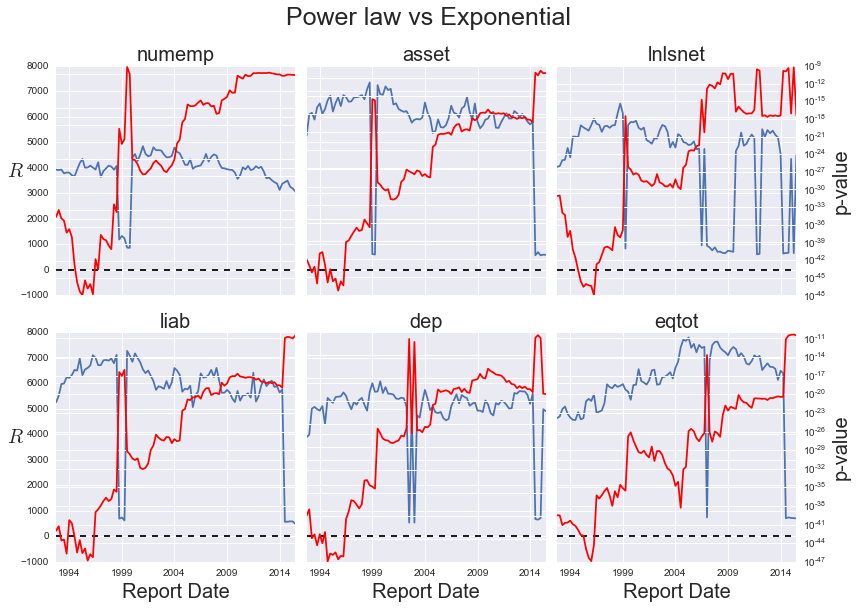

In [339]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
likelihood_ratio_results(fig, axes, "exponential")
fig.suptitle("Power law vs Exponential", x=0.5, y=1.05, fontsize=25)
plt.savefig('./assets/img/power-law-vs-exponential-llr-results.jpg', bbox_inches='tight')

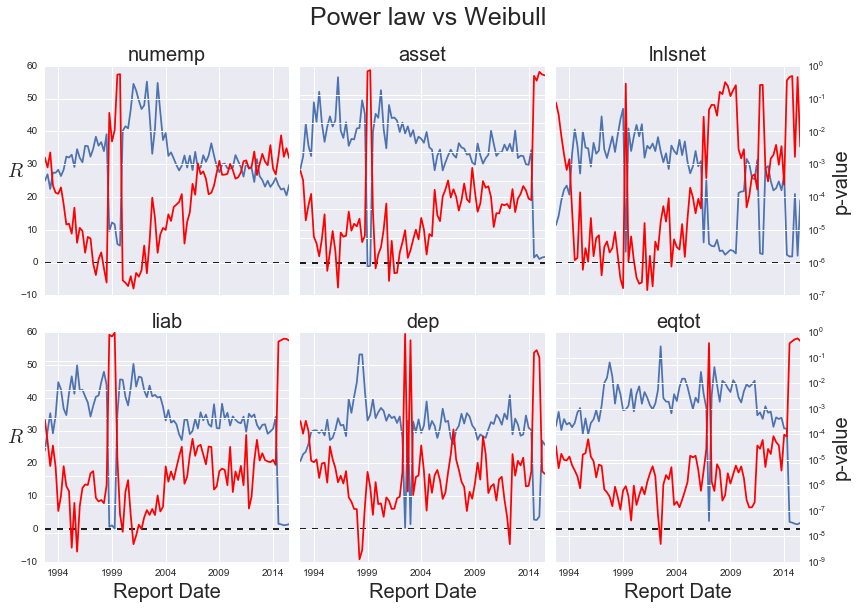

In [340]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
likelihood_ratio_results(fig, axes, "stretched_exponential")
fig.suptitle("Power law vs Weibull", x=0.5, y=1.05, fontsize=25)
plt.savefig('./assets/img/power-law-vs-weibull-llr-results.jpg', bbox_inches='tight')

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

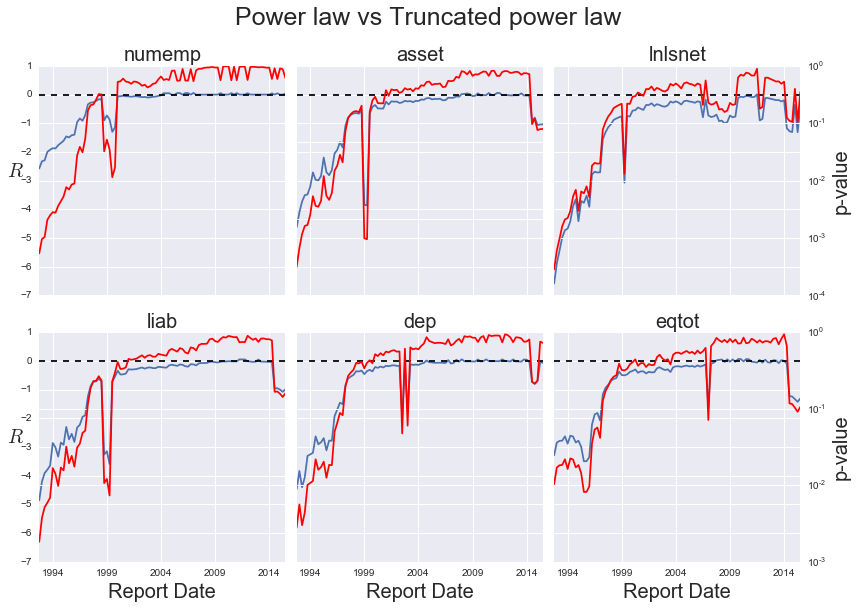

In [341]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
likelihood_ratio_results(fig, axes, "truncated_power_law")
fig.suptitle("Power law vs Truncated power law", x=0.5, y=1.05, fontsize=25)
plt.savefig('./assets/img/power-law-vs-truncated-power-law-llr-results.jpg', bbox_inches='tight')

<img src="./assets/img/power-law-vs-exponential-llr-results.jpg" alt="Power law vs exponential">

<img src="./assets/img/power-law-vs-weibull-llr-results.jpg" alt="Power law vs weibull">

<img src="./assets/img/power-law-vs-truncated-power-law-llr-results.jpg" alt="Power law vs truncated power law">

<h3>Summary</h3>
<ul>
  <li>Power law model clearly preferred to both the exponential distribution and the stretched exponential (Weibull) distributions (not at all surprising...but a nice sanity check).</li>
  <li>Finally, while the power law distribution with an exponential cut-off is preferred over the pure power law model in the early 1990's, this distribution becomes less plausible over time.</li>
</ul>  

<h2> Conclusions </h2>

<p>Statistically significant departures from Zipf's Law for most measures of bank size in most years...</p>
<ul>
  <li>$\hat{\alpha}$ consistently less than 2 indicates that U.S. the banking sector is too concentrated to be consistent with the predictions of Zipf's Law.</li>
  <li>Likelihood ratio testing results indicate that the power law model out-performs other distributions commonly used to model heavy-tailed data.</li>
</ul>

<strong>Conclusion:</strong> Power law distribution with $\hat{\alpha} \approx 1.9$ is a pretty good model for the upper tail of the size distribution of U.S. banks.

<h2> Thanks! </h2>